Lingpei(Jocelyn) Luo -- Bank Fraud Analysis for Data challenge

# Load the dateset

In [1]:
# Sklearn and Pandas Setup
import json
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from wordcloud import WordCloud

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1MEZRWv_VwQ7PxChZJu0uDNqAI9RzHldo/view?usp=share_link'
id = '1MEZRWv_VwQ7PxChZJu0uDNqAI9RzHldo'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('sp23_datachallenge.csv')  
bank_df = pd.read_csv('sp23_datachallenge.csv')

In [4]:
bank_df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


# Check rows, columns, and duplicates

In [5]:
#all rows are filled
bank_df_clean = bank_df.dropna(axis = 0, how = 'any')

In [6]:
def find_empty_columns(df):
    df_missing_columns = df.isnull().sum(axis=0).reset_index()
    df_missing_columns.columns = ['name', 'count']
    df_missing_columns['ratio'] = (df.shape[0]-df_missing_columns['count']) / df.shape[0]
    return df_missing_columns

In [7]:
# there are no columns that have no value
df_missing_columns = find_empty_columns(bank_df_clean)
print(df_missing_columns[df_missing_columns['ratio'] == 0])

Empty DataFrame
Columns: [name, count, ratio]
Index: []


In [8]:
#TO-DO: Drop the duplicate rows
bank_df_clean.drop_duplicates(inplace = True)

In [9]:
bank_df_clean

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


# EDA Analysis

In [10]:
bank_df_clean.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


From the descriptive data, we have seen that the columns of device_fraud_appl which supposed to be at range (0,1), has exclusively 0. We consider dropping this column.

In [11]:
bank_df_clean.drop(columns= ['device_fraud_count'], inplace = True)

In [12]:
corr_matrix = bank_df_clean.corr()

corr_matrix

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
fraud_bool,1.000000,0.045079,-0.036720,-0.026031,0.033701,0.062959,0.000567,-0.024524,0.005212,-0.016892,...,-0.035128,-0.013180,-0.003222,-0.035156,0.068907,0.016885,0.008999,-0.050296,0.035704,0.013250
income,0.045079,1.000000,-0.038519,0.018209,-0.036985,0.125822,-0.015877,0.059046,-0.080581,-0.096431,...,0.024938,0.014979,-0.004514,0.086861,0.108868,0.011452,-0.055430,-0.043584,-0.009992,0.116479
name_email_similarity,-0.036720,-0.038519,1.000000,-0.018186,0.050305,-0.048902,-0.007736,0.029040,0.025114,0.024881,...,-0.002931,0.008966,-0.006351,0.011021,0.073159,-0.015224,0.005998,0.014342,-0.017804,-0.042949
prev_address_months_count,-0.026031,0.018209,-0.018186,1.000000,-0.271730,-0.069178,0.078107,-0.009428,-0.029638,-0.001265,...,-0.053353,0.004757,-0.045550,-0.042949,-0.028474,0.019242,0.051425,0.031672,0.011924,-0.001793
current_address_months_count,0.033701,-0.036985,0.050305,-0.271730,1.000000,0.142863,-0.057836,0.057601,0.047286,0.027508,...,0.129102,-0.088268,0.071997,0.060732,0.130594,-0.012355,-0.033574,-0.050539,-0.000760,-0.024541
customer_age,0.062959,0.125822,-0.048902,-0.069178,0.142863,1.000000,-0.035999,-0.013000,-0.014176,-0.022063,...,0.212713,-0.147098,0.012907,0.108743,0.148857,-0.001606,0.025049,-0.024272,0.025709,0.005694
days_since_request,0.000567,-0.015877,-0.007736,0.078107,-0.057836,-0.035999,1.000000,0.019782,0.000249,0.027968,...,-0.042009,0.005130,-0.027460,-0.048861,-0.068670,0.001066,0.049613,0.000337,0.009025,-0.017938
intended_balcon_amount,-0.024524,0.059046,0.029040,-0.009428,0.057601,-0.013000,0.019782,1.000000,0.002251,0.042849,...,0.000019,0.038625,0.178374,0.096676,0.057860,0.007933,0.022811,-0.020689,-0.019910,-0.043070
zip_count_4w,0.005212,-0.080581,0.025114,-0.029638,0.047286,-0.014176,0.000249,0.002251,1.000000,0.142372,...,-0.035661,0.012122,0.053637,-0.015015,-0.011651,0.017212,0.039687,0.022283,0.020550,-0.287203
velocity_6h,-0.016892,-0.096431,0.024881,-0.001265,0.027508,-0.022063,0.027968,0.042849,0.142372,1.000000,...,-0.036820,-0.010751,0.014874,-0.007049,-0.025005,-0.000450,0.054491,0.002797,0.030030,-0.409148


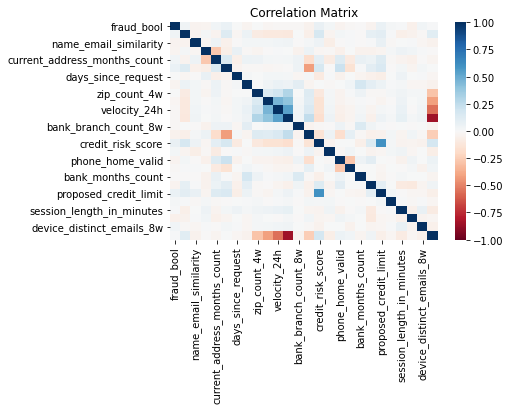

In [13]:
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")
plt.show() 

In [14]:
bank_df_clean.groupby(by = "customer_age").mean()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
customer_age,,,,,,,,,,,,,,,,,,,,,
10,0.003526,0.421709,0.569577,17.726688,115.260733,1.330070,10.796707,1461.270501,5764.421062,4774.382856,...,0.297136,0.932911,10.979559,0.064516,368.310859,0.015105,8.991966,0.491638,1.018392,3.575261
20,0.004901,0.499902,0.520216,19.782022,82.840398,1.232941,8.574965,1613.192235,5948.033389,4888.799178,...,0.301641,0.930540,10.963320,0.144398,409.387159,0.025544,7.562131,0.567489,1.016209,3.160973
30,0.008313,0.567089,0.476803,19.882103,65.650406,1.173082,9.259012,1584.995710,5531.488736,4703.963089,...,0.364762,0.917645,10.722849,0.240453,509.897763,0.027691,7.136261,0.615702,1.015104,3.291443
40,0.012048,0.611559,0.491483,13.005027,90.187812,0.816062,7.830104,1522.963244,5452.287537,4664.128603,...,0.480114,0.873073,10.251127,0.255425,558.995610,0.022651,7.227150,0.577281,1.013569,3.494131
50,0.019985,0.599446,0.487635,11.934479,113.935826,0.724327,8.762979,1579.053572,5790.243232,4856.186424,...,0.569407,0.823445,11.444871,0.280087,645.254822,0.025329,8.440490,0.544427,1.030986,3.146395
60,0.033046,0.569111,0.466101,11.742767,135.911475,0.763282,7.979988,1567.829767,5769.696463,4892.190422,...,0.664165,0.747915,12.047944,0.256572,584.709232,0.024907,8.683105,0.498332,1.042278,3.150043
70,0.040356,0.561163,0.433684,13.157434,140.481356,0.775713,8.414290,1535.299524,5675.567473,4781.016251,...,0.686052,0.708915,12.776431,0.259168,553.859138,0.024244,8.097238,0.483505,1.021789,3.315789
80,0.049345,0.557903,0.402620,12.939861,142.666153,0.946395,8.608239,1520.861218,5449.172224,4702.027991,...,0.715497,0.669237,13.370085,0.256746,528.627602,0.026214,7.352641,0.483423,1.027756,3.370085
90,0.052632,0.557895,0.415919,10.052632,133.105263,0.560069,8.326989,1670.605263,5325.699178,4674.460168,...,0.828947,0.723684,14.973684,0.276316,585.789474,0.013158,6.549215,0.500000,1.013158,3.039474


From a quick EDA about customer age, we can see that, 

*   Customer with an age higher tends to have a higher tendancy of fraud. 
*   Customer with the age of 20, 30, 40 has lower current address months count. Customer with age of 20, 30 has lower value in prev address months count as well, this might indicates that people tends to relocate in their careers.
*   Customer with age of 10 has lowest fraud_bool, zip_count_4w, proposed_credit_limit. highest name_email_similarity, intended_balcon_count, session_length_in_minutes.





In [15]:
bank_df_clean.groupby(by = "income").mean()

,fraud_bool,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
income,,,,,,,,,,,,,,,,,,,,,
0.1,0.005773,0.513987,15.074234,93.670998,31.347547,1.155794,6.539684,1701.113967,6085.075808,4983.835646,...,0.395042,0.881104,10.805359,0.164231,440.122960,0.022172,8.202895,0.610007,1.021645,2.911692
0.2,0.006316,0.505762,15.925431,89.733852,32.160213,1.096543,7.441304,1656.114240,5980.084724,4922.574824,...,0.402019,0.885125,10.896474,0.184584,461.999567,0.024198,8.030169,0.600389,1.020131,3.021948
0.3,0.006649,0.500444,15.965987,87.793579,32.467492,1.136636,7.741157,1635.733185,5915.715519,4905.682476,...,0.406763,0.887671,10.900478,0.194087,473.389334,0.024000,7.902600,0.594948,1.019535,3.061928
0.4,0.007337,0.496796,16.656666,87.667334,32.840077,1.093591,7.960302,1616.433976,5845.064399,4860.104059,...,0.412922,0.887592,10.910575,0.203284,480.907404,0.024433,7.856572,0.588577,1.018079,3.128964
0.5,0.007949,0.496969,16.681281,86.593451,33.237495,1.044250,8.505753,1601.362705,5799.193515,4852.177038,...,0.419081,0.886444,11.018833,0.213559,493.279029,0.024795,7.716227,0.584625,1.019872,3.164972
0.6,0.008779,0.492289,17.093219,84.949041,33.489234,1.033632,8.880310,1580.280684,5717.652749,4805.525371,...,0.418029,0.890447,10.977012,0.222509,503.370991,0.025024,7.582111,0.580310,1.018290,3.242916
0.7,0.008819,0.487987,17.325824,83.432056,33.949043,0.991250,9.346071,1550.881542,5617.654296,4752.949063,...,0.424179,0.891836,11.000076,0.234652,516.729966,0.024850,7.473216,0.570208,1.016897,3.323892
0.8,0.010924,0.483704,17.653004,82.838098,34.573202,0.949563,9.882612,1515.230979,5488.069172,4674.776038,...,0.430297,0.895465,10.880116,0.252458,540.615070,0.026069,7.251619,0.562264,1.017225,3.470474
0.9,0.021638,0.482005,17.244541,84.701354,35.931379,0.918702,9.816302,1462.040010,5224.401202,4537.381095,...,0.428242,0.893988,10.587018,0.268238,604.341407,0.028195,6.894795,0.546977,1.016187,3.668240


From a quick EDA about customer income, we can see that, 

*   Customer with an income (0.6, 0.7, 0.8, 0.9) higher tends to have a higher value of prev address months count and intended balcon amount. While customer with lowest income (0.1) tends to have highest value of current address months count. 
*   Customer with the income of 0.9 has a higher proposed_credit_limit and higher fraud_bool.


# Clustering

In [16]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


In [17]:
from numpy.random.mtrand import normal
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def create_features(df):
  
    df.dropna(how = 'all', axis = 0, inplace=True)
    df.fillna(0, inplace = True)
    x = df.values # numpy array
    scaler = preprocessing.StandardScaler()
    x_scaled = scaler.fit_transform(x)

    return pd.DataFrame(x_scaled)




def run_pipeline(k, X_norm, pca_component):
    pca = PCA(n_components = 3, random_state = 0) # 3D PCA for the plot
    reduced = pd.DataFrame(pca.fit_transform(X_norm))

    kmeans = KMeans(n_clusters=k, random_state = 0)
    
    # Make this student todos 
    # fit the input data
    kmeans = kmeans.fit(reduced)
    # get the cluster labels
    labels = kmeans.predict(reduced)
    # centroid values
    centroid = kmeans.cluster_centers_
    # cluster values
    clusters = kmeans.labels_.tolist()

    reduced['cluster'] = clusters

    reduced.columns = ['x', 'y', 'z', 'cluster']

    if(pca_component):
      return reduced, pca.components_

    return reduced

def plot_curves(reduced):
    %matplotlib inline
    sns.set(style="white")

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)
    fig.add_axes(ax)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

    # plot
    sc = ax.scatter(xs=reduced.x, ys=reduced.y, zs=reduced.z,c=reduced.cluster, cmap=cmap, alpha=1)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


    # save
    plt.savefig("scatter_hue", bbox_inches='tight')


In [18]:
bank_cluster_df = bank_df_clean.drop(columns = ['payment_type', 'employment_status','housing_status', 'source','device_os'])
X_norm = create_features(bank_cluster_df)
# first, we choose our cluster number to be 15 (we will later re-choose another cluster number)
k = 15
km = run_pipeline(k, X_norm, False)
# do a groupby to see how our clusters perform
km.groupby('cluster').count().sort_values('x', ascending = False)

,x,y,z
cluster,,,
0,95720,95720,95720
14,94001,94001,94001
9,92599,92599,92599
7,79844,79844,79844
5,74352,74352,74352
12,74131,74131,74131
6,73619,73619,73619
8,60787,60787,60787
4,58970,58970,58970


In [19]:
def deciding_k(K, X_norm):
    pca = PCA(n_components = 3, random_state = 0) # 3D PCA for the plot
    reduced = pd.DataFrame(pca.fit_transform(X_norm))
  

    #compute the distortion
    Sum_of_squared_distances = []

    for k in K:
      kmeans = KMeans(n_clusters=k, max_iter = 100, random_state = 0)  
     
      # fit the input data
      kmeans = kmeans.fit(reduced)
      # get the cluster labels
      labels = kmeans.predict(reduced)
      # centroid values
      centroid = kmeans.cluster_centers_
      # cluster values
      clusters = kmeans.labels_.tolist()
      Sum_of_squared_distances.append(kmeans.inertia_)

    return Sum_of_squared_distances

In [20]:
K = range(1,15)
X_norm = create_features(bank_cluster_df)
distortion = deciding_k(K, X_norm)

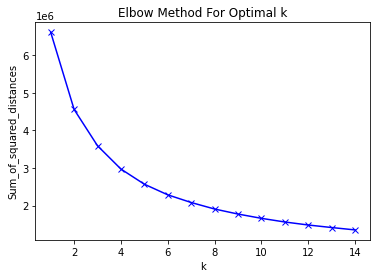

In [21]:
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
# 8 is our chosen cluster number 
k = 8
X_norm = create_features(bank_cluster_df)
km, pca = run_pipeline(k, X_norm, pca_component=True)

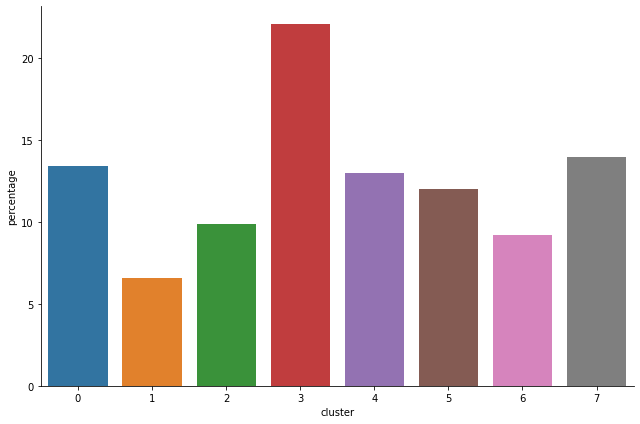

In [23]:
clusters_dist = km.groupby('cluster').count().sort_values('x', ascending = False)
clusters_dist.reset_index(drop = False, inplace = True)
clusters_dist['percentage'] = (clusters_dist.x/clusters_dist.x.sum())*100
sns.catplot(x= 'cluster', y = 'percentage', hue = 'cluster', data = clusters_dist, kind = 'bar', height = 6, aspect = 1.5, dodge = False )


<ipython-input-17-949d329298d0>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


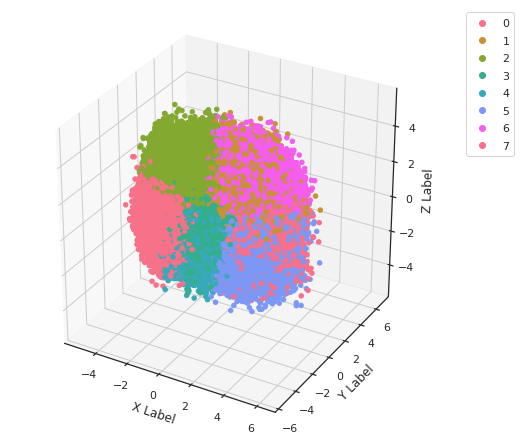

In [24]:
plot_curves(km)

In [25]:
pca

array([[-0.03037194, -0.14330874,  0.03180929,  0.02227163, -0.02878164,
        -0.11019027,  0.04281577,  0.03488577,  0.24462195,  0.34938614,
         0.41406786,  0.4821943 ,  0.01829874,  0.24097156, -0.22125035,
         0.05681461, -0.09110666,  0.01158814,  0.03296777, -0.07841515,
        -0.07106656,  0.0157859 ,  0.07964549,  0.02594713,  0.04093645,
        -0.48465795],
       [ 0.07591109,  0.11588945,  0.06626847, -0.19679813,  0.34837635,
         0.40421174, -0.11601118,  0.12523989,  0.07444637,  0.10873947,
         0.15020491,  0.17171259,  0.12740377, -0.26521446,  0.34071102,
        -0.04538093,  0.24068399, -0.20347235,  0.0768456 ,  0.21000501,
         0.40618677,  0.00826591,  0.00540209, -0.07711583,  0.01030299,
        -0.17084156],
       [ 0.08894204,  0.16740585,  0.11548277,  0.15996616, -0.15519537,
        -0.20264996, -0.01641661, -0.00499147, -0.02630199, -0.02319681,
         0.02116221,  0.05703566, -0.15331432,  0.26915612,  0.47658652,
       

In [26]:
for cluster in np.unique(km.cluster):
    display("Cluster "+str(cluster))
    display(km[km['cluster'] == cluster].describe())

'Cluster 0'

,x,y,z,cluster
count,134107.000000,134107.000000,134107.000000,134107.0
mean,-2.099858,-1.355372,-0.135427,0.0
std,0.745957,0.725754,0.755126,0.0
min,-4.552834,-5.481383,-3.038675,0.0
25%,-2.684902,-1.832090,-0.657335,0.0
50%,-2.063150,-1.296584,-0.147458,0.0
75%,-1.469818,-0.825020,0.355924,0.0
max,-0.473486,0.689756,3.707639,0.0


'Cluster 1'

,x,y,z,cluster
count,65853.000000,65853.000000,65853.000000,65853.0
mean,-0.286576,2.809235,0.370020,1.0
std,1.013863,0.836676,0.941117,0.0
min,-4.703961,0.865525,-3.979008,1.0
25%,-0.935367,2.203985,-0.230609,1.0
50%,-0.322391,2.750102,0.380960,1.0
75%,0.343705,3.344216,1.008848,1.0
max,4.187880,6.743711,4.119693,1.0


'Cluster 2'

,x,y,z,cluster
count,98743.000000,98743.000000,98743.000000,98743.0
mean,-1.913189,0.805035,1.340853,2.0
std,0.949865,0.867229,0.831000,0.0
min,-5.183806,-2.450052,-0.890276,2.0
25%,-2.582575,0.167710,0.700766,2.0
50%,-1.779397,0.761656,1.293688,2.0
75%,-1.135528,1.407372,1.917824,2.0
max,-0.256125,4.507500,5.328699,2.0


'Cluster 3'

,x,y,z,cluster
count,220325.000000,220325.000000,220325.000000,220325.0
mean,0.286639,-1.089205,0.186061,3.0
std,0.640582,0.723948,0.729825,0.0
min,-1.165037,-5.482083,-3.085773,3.0
25%,-0.230976,-1.565362,-0.314415,3.0
50%,0.285947,-1.053620,0.166566,3.0
75%,0.814819,-0.567896,0.658541,3.0
max,2.053155,0.822295,4.374185,3.0


'Cluster 4'

,x,y,z,cluster
count,129659.000000,129659.000000,129659.000000,129659.0
mean,-1.329761,0.483791,-1.293002,4.0
std,0.852147,0.793599,0.750045,0.0
min,-4.918873,-2.119078,-5.142151,4.0
25%,-1.881936,-0.096629,-1.775796,4.0
50%,-1.190300,0.397239,-1.230261,4.0
75%,-0.661172,0.986223,-0.738232,4.0
max,0.195433,3.932300,0.299379,4.0


'Cluster 5'

,x,y,z,cluster
count,119967.000000,119967.000000,119967.000000,119967.0
mean,1.259736,0.878677,-1.449511,5.0
std,0.851717,0.866640,0.814547,0.0
min,-0.602909,-1.880115,-5.141831,5.0
25%,0.582916,0.253065,-1.967564,5.0
50%,1.162503,0.785537,-1.381111,5.0
75%,1.823390,1.419620,-0.860360,5.0
max,5.079142,5.082372,0.183989,5.0


'Cluster 6'

,x,y,z,cluster
count,91723.000000,91723.000000,91723.000000,91723.0
mean,1.094141,1.031654,1.722101,6.0
std,0.960945,0.864671,0.809192,0.0
min,-0.876629,-2.324944,0.091734,6.0
25%,0.316564,0.413387,1.115719,6.0
50%,0.993746,0.983944,1.708011,6.0
75%,1.769703,1.619076,2.287424,6.0
max,5.061688,4.449381,5.300852,6.0


'Cluster 7'

,x,y,z,cluster
count,139623.000000,139623.000000,139623.000000,139623.0
mean,2.486472,-0.755682,0.028558,7.0
std,0.754604,0.780951,0.735260,0.0
min,1.205292,-4.755453,-3.063285,7.0
25%,1.869937,-1.278414,-0.471536,7.0
50%,2.375685,-0.752736,0.014409,7.0
75%,2.990841,-0.225542,0.505712,7.0
max,6.259274,2.262171,3.726603,7.0


# Gaussian Mixture Model

In [27]:
%%time
from sklearn.mixture import GaussianMixture

#creatig features
X_train = bank_cluster_df.values

#choosing cluster number
n_clusters = 8

#create the model
max_iter = 100
model = GaussianMixture(n_components=n_clusters, covariance_type="full", n_init = 5, max_iter = max_iter)
#fit model on data
model.fit(X_train)

#predict cluster number for the date
results = bank_cluster_df
results["cluster"] = model.predict(X_train)

CPU times: user 19min 30s, sys: 4min 59s, total: 24min 29s
Wall time: 13min 45s


In [28]:
for cluster in range(0,n_clusters):
    display("Cluster "+str(cluster))
    display(results[results['cluster'] == cluster].describe())

'Cluster 0'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,26159.0,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,...,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.0
mean,0.0,0.577002,0.466799,30.016858,72.867541,33.622080,0.013485,9.677255,1678.073091,5707.424334,...,0.883329,10.524179,0.227379,573.910318,0.834703,8.296254,0.513590,1.165297,2.967315,0.0
std,0.0,0.287227,0.296010,57.708587,88.098519,11.799138,0.009922,22.453258,1075.400382,3120.135872,...,0.321034,11.727404,0.419147,514.596786,0.371455,8.613620,0.499825,0.371455,2.283077,0.0
min,0.0,0.100000,0.000030,-1.000000,-1.000000,10.000000,0.000001,-11.369197,4.000000,-37.020678,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.0
25%,0.0,0.300000,0.183897,-1.000000,10.000000,20.000000,0.005542,-1.157468,913.500000,3335.803199,...,1.000000,1.000000,0.000000,200.000000,1.000000,3.413538,0.000000,1.000000,1.000000,0.0
50%,0.0,0.600000,0.463959,-1.000000,37.000000,30.000000,0.011585,-0.815541,1378.000000,5325.544227,...,1.000000,5.000000,0.000000,200.000000,1.000000,5.536431,1.000000,1.000000,3.000000,0.0
75%,0.0,0.800000,0.733733,34.000000,103.000000,40.000000,0.019455,-0.035357,2126.000000,7786.596921,...,1.000000,21.000000,0.000000,1000.000000,1.000000,9.943622,1.000000,1.000000,5.000000,0.0
max,0.0,0.900000,0.999995,359.000000,392.000000,80.000000,0.062864,111.868497,6540.000000,16388.219788,...,1.000000,31.000000,1.000000,2100.000000,1.000000,82.254078,1.000000,2.000000,7.000000,0.0


'Cluster 1'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,44033.0,44033.000000,44033.000000,44033.000000,44033.000000,44033.000000,4.403300e+04,44033.000000,44033.000000,44033.000000,...,44033.000000,44033.000000,44033.000000,44033.000000,44033.0,44033.000000,44033.000000,44033.0,44033.000000,44033.0
mean,0.0,0.580358,0.498799,106.691050,65.771217,34.552722,5.036061e+00,13.368242,1574.911226,6049.696634,...,0.738651,10.241251,0.271683,716.967275,0.0,9.958904,0.571594,1.0,3.035655,1.0
std,0.0,0.286647,0.291588,115.616445,90.142554,12.432061,7.801583e+00,23.626595,998.272802,2966.829318,...,0.439375,12.136851,0.444832,515.693332,0.0,10.940611,0.494853,0.0,2.068229,0.0
min,0.0,0.100000,0.000078,-1.000000,-1.000000,10.000000,6.467590e-08,-10.035337,1.000000,57.172855,...,0.000000,-1.000000,0.000000,190.000000,0.0,-1.000000,0.000000,1.0,0.000000,1.0
25%,0.0,0.300000,0.234898,-1.000000,8.000000,30.000000,1.601588e-02,-1.089766,890.000000,3791.114627,...,0.000000,-1.000000,0.000000,200.000000,0.0,3.894743,0.000000,1.0,1.000000,1.0
50%,0.0,0.600000,0.486709,76.000000,19.000000,30.000000,9.899155e-01,-0.652470,1304.000000,5918.090420,...,1.000000,3.000000,0.000000,500.000000,0.0,6.390124,1.000000,1.0,3.000000,1.0
75%,0.0,0.800000,0.761090,199.000000,86.000000,40.000000,7.976847e+00,24.599761,1924.000000,8118.424169,...,1.000000,22.000000,1.000000,1000.000000,0.0,11.316752,1.000000,1.0,4.000000,1.0
max,0.0,0.900000,0.999999,383.000000,404.000000,90.000000,3.831782e+01,111.281649,6525.000000,16189.420225,...,1.000000,32.000000,1.000000,2100.000000,0.0,82.299327,1.000000,1.0,7.000000,1.0


'Cluster 2'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,144480.0,144480.000000,144480.000000,144480.000000,144480.000000,144480.000000,1.444800e+05,144480.000000,144480.000000,144480.000000,...,144480.000000,144480.000000,144480.000000,144480.000000,144480.0,144480.000000,144480.000000,144480.0,144480.000000,144480.0
mean,0.0,0.618587,0.516400,4.807274,108.976751,37.220238,1.590942e-02,10.465519,1526.312666,5497.981924,...,0.785638,11.671989,0.695252,921.166459,0.0,5.745026,0.522619,1.0,3.354942,2.0
std,0.0,0.276965,0.290971,14.126106,94.409068,11.566148,1.124263e-02,19.291352,949.014633,3040.416423,...,0.410380,11.933926,0.460302,495.731597,0.0,4.568117,0.499490,0.0,2.104434,0.0
min,0.0,0.100000,0.000038,-1.000000,-1.000000,10.000000,3.112791e-08,-14.383932,2.000000,-89.566496,...,0.000000,-1.000000,0.000000,190.000000,0.0,-1.000000,0.000000,1.0,0.000000,2.0
25%,0.0,0.400000,0.243786,-1.000000,36.000000,30.000000,6.749260e-03,-1.106574,907.000000,3266.021187,...,1.000000,1.000000,0.000000,500.000000,0.0,2.665424,0.000000,1.0,2.000000,2.0
50%,0.0,0.700000,0.528204,-1.000000,76.000000,40.000000,1.402165e-02,-0.715532,1237.000000,5182.485624,...,1.000000,6.000000,1.000000,1000.000000,0.0,4.472745,1.000000,1.0,3.000000,2.0
75%,0.0,0.900000,0.782439,-1.000000,167.000000,50.000000,2.316281e-02,20.250264,1826.000000,7489.102136,...,1.000000,25.000000,1.000000,1500.000000,0.0,7.061654,1.000000,1.0,5.000000,2.0
max,0.0,0.900000,0.999998,75.000000,418.000000,90.000000,6.935945e-02,111.430651,6634.000000,16665.359533,...,1.000000,32.000000,1.000000,2100.000000,0.0,32.758830,1.000000,1.0,7.000000,2.0


'Cluster 3'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,...,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.000000,15472.0
mean,0.217102,0.560147,0.442248,32.381205,74.323164,35.354835,21.014051,7.516271,1631.329175,6073.161277,...,0.842425,7.534126,0.124871,472.237590,0.220204,9.760515,0.376228,1.223630,2.884889,3.0
std,0.412286,0.294908,0.292619,59.725360,87.292263,13.122859,28.661498,20.055720,1016.518781,2891.838623,...,0.364354,11.868622,0.330583,497.491135,0.414398,10.969542,0.484454,0.700252,2.096872,0.0
min,0.000000,0.100000,0.000019,-1.000000,-1.000000,10.000000,0.000002,-8.825505,13.000000,75.239846,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,3.0
25%,0.000000,0.300000,0.171191,-1.000000,10.000000,30.000000,0.785479,-1.173111,912.000000,3938.053280,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.467159,0.000000,1.000000,1.000000,3.0
50%,0.000000,0.600000,0.421750,-1.000000,40.000000,30.000000,3.746011,-0.847779,1327.000000,5862.392785,...,1.000000,-1.000000,0.000000,200.000000,0.000000,6.313843,0.000000,1.000000,2.000000,3.0
75%,0.000000,0.800000,0.690313,37.000000,110.000000,40.000000,28.280027,-0.357954,2103.000000,8000.201326,...,1.000000,16.000000,0.000000,500.000000,0.000000,11.804064,1.000000,2.000000,4.000000,3.0
max,1.000000,0.900000,0.999986,364.000000,408.000000,90.000000,78.456904,111.321272,6368.000000,16200.506895,...,1.000000,31.000000,1.000000,2100.000000,1.000000,80.403640,1.000000,2.000000,7.000000,3.0


'Cluster 4'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,24245.0,24245.000000,24245.000000,24245.000000,24245.000000,24245.000000,24245.000000,24245.000000,24245.000000,24245.000000,...,24245.000000,24245.000000,24245.000000,24245.000000,24245.0,24245.000000,24245.000000,24245.000000,24245.000000,24245.0
mean,0.0,0.538532,0.479413,0.903114,106.102248,37.413900,0.014361,4.142209,1723.564281,6190.014994,...,0.773809,10.456548,0.251021,542.117138,0.0,16.402042,0.294122,1.434234,2.567251,4.0
std,0.0,0.291236,0.284468,6.443590,87.092011,13.008589,0.010396,13.297507,1056.478061,3126.852858,...,0.418373,12.302466,0.433609,517.091610,0.0,18.695132,0.455657,0.806118,2.055548,0.0
min,0.0,0.100000,0.000032,-1.000000,-1.000000,10.000000,0.000001,-12.537085,5.000000,-74.983185,...,0.000000,-1.000000,0.000000,190.000000,0.0,-1.000000,0.000000,-1.000000,0.000000,4.0
25%,0.0,0.200000,0.217039,-1.000000,41.000000,30.000000,0.005908,-1.182047,979.000000,3927.734005,...,1.000000,-1.000000,0.000000,200.000000,0.0,3.634266,0.000000,1.000000,1.000000,4.0
50%,0.0,0.600000,0.480916,-1.000000,79.000000,40.000000,0.012460,-0.875748,1353.000000,5865.159465,...,1.000000,4.000000,0.000000,200.000000,0.0,7.694399,0.000000,2.000000,2.000000,4.0
75%,0.0,0.800000,0.727089,-1.000000,153.000000,50.000000,0.021005,-0.497502,2296.000000,8079.695674,...,1.000000,25.000000,1.000000,1000.000000,0.0,24.775698,1.000000,2.000000,4.000000,4.0
max,0.0,0.900000,0.999993,59.000000,393.000000,90.000000,0.071232,109.170043,6325.000000,16556.028555,...,1.000000,31.000000,1.000000,2100.000000,0.0,85.899143,1.000000,2.000000,7.000000,4.0


'Cluster 5'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,223218.0,223218.000000,223218.000000,223218.000000,223218.000000,223218.000000,2.232180e+05,223218.000000,223218.000000,223218.000000,...,223218.000000,223218.000000,223218.0,223218.000000,223218.0,223218.000000,223218.000000,223218.0,223218.000000,223218.0
mean,0.0,0.586315,0.516141,13.217706,94.014228,34.793386,1.505561e-02,5.851124,1526.177418,5352.942168,...,0.756588,9.729435,0.0,888.583224,0.0,7.470808,0.593993,1.0,3.388844,5.0
std,0.0,0.287406,0.285311,30.492593,91.429054,12.052538,1.077859e-02,16.622359,999.109260,3052.967221,...,0.429143,11.983510,0.0,505.606554,0.0,7.165201,0.491087,0.0,2.229950,0.0
min,0.0,0.100000,0.000010,-1.000000,-1.000000,10.000000,2.473609e-07,-13.901393,1.000000,-170.603072,...,0.000000,-1.000000,0.0,190.000000,0.0,-1.000000,0.000000,1.0,0.000000,5.0
25%,0.0,0.300000,0.256613,-1.000000,19.000000,30.000000,6.309381e-03,-1.164443,853.000000,3005.971352,...,1.000000,-1.000000,0.0,500.000000,0.0,3.295625,0.000000,1.0,2.000000,5.0
50%,0.0,0.700000,0.520984,-1.000000,60.000000,30.000000,1.313405e-02,-0.845108,1236.000000,5021.128867,...,1.000000,2.000000,0.0,1000.000000,0.0,5.325979,1.000000,1.0,3.000000,5.0
75%,0.0,0.900000,0.777359,12.000000,150.000000,40.000000,2.189978e-02,-0.429981,1863.000000,7385.763812,...,1.000000,21.000000,0.0,1500.000000,0.0,8.958539,1.000000,1.0,5.000000,5.0
max,0.0,0.900000,0.999999,206.000000,406.000000,90.000000,7.947090e-02,110.893211,6568.000000,16715.565404,...,1.000000,32.000000,0.0,2100.000000,0.0,65.014848,1.000000,1.0,7.000000,5.0


'Cluster 6'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,19726.000000,19726.000000,19726.000000,19726.0,19726.000000,19726.000000,1.972600e+04,19726.000000,19726.000000,19726.000000,...,19726.000000,19726.000000,19726.000000,19726.000000,19726.0,19726.000000,19726.000000,19726.0,19726.000000,19726.0
mean,0.388827,0.643501,0.475026,-1.0,124.184680,38.378789,1.523265e-02,62.799372,1570.919446,5481.535873,...,0.871388,12.787945,0.236287,854.024131,0.0,7.381365,0.490672,1.0,3.394555,6.0
std,0.487496,0.275549,0.299237,0.0,87.916359,12.831666,1.088661e-02,48.998862,984.851408,3053.610843,...,0.334778,12.145380,0.424811,601.338506,0.0,8.142768,0.499926,0.0,2.237441,0.0
min,0.000000,0.100000,0.000113,-1.0,0.000000,10.000000,1.414624e-07,-6.264141,9.000000,64.422571,...,0.000000,-1.000000,0.000000,190.000000,0.0,-1.000000,0.000000,1.0,0.000000,6.0
25%,0.000000,0.400000,0.183553,-1.0,53.000000,30.000000,6.378838e-03,-0.748247,906.000000,3160.464183,...,1.000000,1.000000,0.000000,200.000000,0.0,3.160763,0.000000,1.0,1.000000,6.0
50%,0.000000,0.700000,0.475287,-1.0,100.000000,40.000000,1.338782e-02,97.572060,1266.000000,5116.825555,...,1.000000,10.000000,0.000000,500.000000,0.0,4.975132,0.000000,1.0,3.000000,6.0
75%,1.000000,0.900000,0.760774,-1.0,177.000000,50.000000,2.221694e-02,102.515055,1906.000000,7590.500445,...,1.000000,26.000000,0.000000,1500.000000,0.0,8.199268,1.000000,1.0,5.000000,6.0
max,1.000000,0.900000,0.999996,-1.0,398.000000,90.000000,6.720274e-02,112.956928,6262.000000,16310.223081,...,1.000000,32.000000,1.000000,2100.000000,0.0,77.730242,1.000000,1.0,7.000000,6.0


'Cluster 7'

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,cluster
count,502667.0,502667.000000,502667.000000,502667.000000,502667.000000,502667.000000,5.026670e+05,502667.000000,502667.000000,502667.000000,...,502667.0,502667.000000,502667.000000,502667.0,502667.0,502667.000000,502667.000000,502667.0,502667.000000,502667.0
mean,0.0,0.531923,0.481157,14.099340,77.353294,31.696610,9.393143e-01,7.054517,1591.987630,5785.577102,...,1.0,11.205335,0.182920,200.0,0.0,7.355667,0.611964,1.0,3.307102,7.0
std,0.0,0.292098,0.288242,33.614816,82.916921,11.587186,3.521726e+00,16.421918,1016.752902,2957.972003,...,0.0,12.185317,0.386602,0.0,0.0,7.525089,0.487303,0.0,2.237435,0.0
min,0.0,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,2.000000,-123.460329,...,1.0,-1.000000,0.000000,200.0,0.0,-1.000000,0.000000,1.0,0.000000,7.0
25%,0.0,0.200000,0.213940,-1.000000,18.000000,20.000000,7.514732e-03,-1.224252,902.000000,3603.089663,...,1.0,-1.000000,0.000000,200.0,0.0,3.050548,0.000000,1.0,1.000000,7.0
50%,0.0,0.600000,0.474440,-1.000000,46.000000,30.000000,1.587794e-02,-0.879432,1267.000000,5407.620359,...,1.0,6.000000,0.000000,200.0,0.0,5.062867,1.000000,1.0,3.000000,7.0
75%,0.0,0.800000,0.737670,12.000000,108.000000,40.000000,2.772828e-02,1.518402,2003.000000,7753.054924,...,1.0,25.000000,0.000000,200.0,0.0,8.818051,1.000000,1.0,5.000000,7.0
max,0.0,0.900000,0.999999,254.000000,428.000000,90.000000,2.863792e+01,112.253107,6700.000000,16640.749743,...,1.0,32.000000,1.000000,200.0,0.0,78.202251,1.000000,1.0,7.000000,7.0


# Classification Model

## Preprocessing 

In [29]:
bank_contents_df = bank_df_clean.drop(columns=['fraud_bool'])

## Feature Engeneering

In [30]:
bank_contents_df = pd.get_dummies(bank_contents_df, columns = ['payment_type', 'employment_status','housing_status', 'source','device_os'])
bank_contents_df

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.9,0.166828,-1,88,50,0.020925,-1.331345,769,10650.765523,3134.319630,...,0,0,0,1,0,0,0,0,1,0
1,0.9,0.296286,-1,144,50,0.005418,-0.816224,366,534.047319,2670.918292,...,0,0,0,1,0,0,0,0,1,0
2,0.9,0.044985,-1,132,40,3.108549,-0.755728,870,4048.534263,2893.621498,...,0,0,0,1,0,0,0,1,0,0
3,0.9,0.159511,-1,22,50,0.019079,-1.205124,810,3457.064063,4054.908412,...,0,0,0,1,0,1,0,0,0,0
4,0.9,0.596414,-1,218,50,0.004441,-0.773276,890,5020.341679,2728.237159,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.6,0.192631,-1,104,40,0.030592,-1.044454,804,7905.711839,8341.468557,...,0,0,0,1,0,1,0,0,0,0
999996,0.8,0.322989,148,9,50,1.628119,-1.409803,3306,5391.470463,4955.170808,...,0,0,0,1,0,0,0,0,1,0
999997,0.8,0.879403,-1,30,20,0.018563,34.692760,1522,8063.102636,5670.654316,...,0,0,0,1,0,0,0,1,0,0
999998,0.9,0.762112,-1,189,20,0.015352,94.661055,1418,8092.641762,3982.582204,...,0,0,0,1,0,0,0,0,1,0


In [31]:
bank_contents_df.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_AA',
       'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CA', 'employment_status_CB',
       'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BA',
       'housing_status_BB', 'housing_status_BC', 'housing_status_BD',
       'housing_stat

## Prepare for modeling

In [32]:
#store the columns to be used as features in a DataFrame called "features" 
features = bank_contents_df
#store the binary classification target variable as "labels"
labels = bank_df_clean['fraud_bool']

In [33]:
from sklearn.model_selection import train_test_split
#conduct 80/20 train-test split
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = seed)

## Imbalance

In [34]:
bank_df_clean['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

Text(0, 0.5, 'The number of fraud')

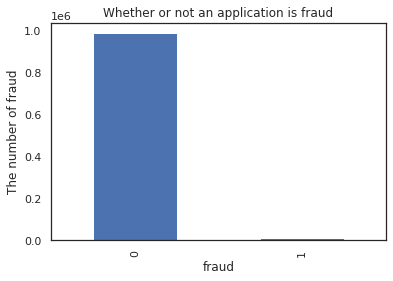

In [35]:
from matplotlib import pyplot as plt
bank_df_clean['fraud_bool'].value_counts().plot(kind="bar", title="test")

plt.title("Whether or not an application is fraud")
plt.xlabel("fraud")
plt.ylabel("The number of fraud")

In [36]:
# use over-sampling to solve data imbalance 
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
x_res, y_res = rus.fit_resample(x_train, y_train)

# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(x_res,y_res)

# #Predict the response for test dataset
# y_pred = clf.predict(x_test)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


In [37]:
x_res.shape

(1582390, 51)

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [39]:
# Initialize model with default parameters and fit it on the training set
reg = LogisticRegression()
reg.fit(x_res, y_res)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(x_test)
# accuracy
train_acc = reg.score(x_res, y_res)
acc = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
train_acc

0.6705395003760135

In [41]:
acc

0.669485

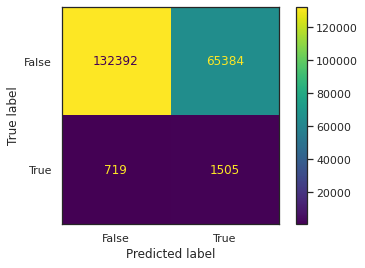

In [42]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

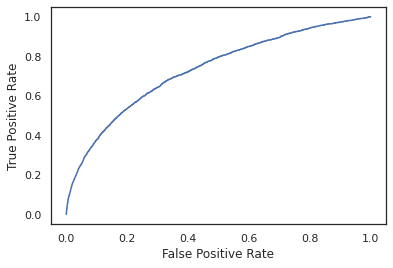

In [43]:
y_pred_proba = reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Decision Tree

In [44]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 10 decision trees
rf = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth=10)
# Train the model on training data
rf.fit(x_res, y_res);

In [45]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)

In [46]:
train_acc = rf.score(x_res, y_res)
test_acc = rf.score(x_test, y_test)

In [47]:
train_acc

0.8477985831558592

In [48]:
test_acc

0.844725

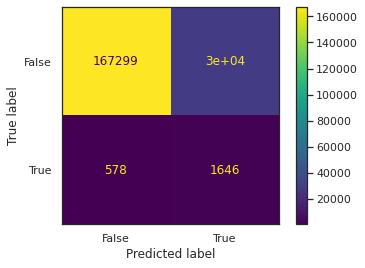

In [49]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    #y_test, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

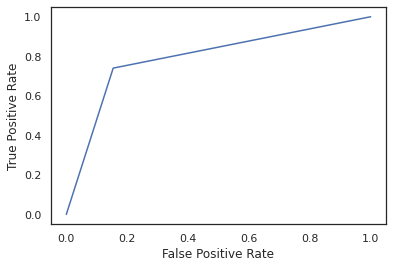

In [50]:
y_pred_proba = reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [51]:
rf.feature_importances_

array([3.40684118e-02, 4.15507154e-02, 6.06446040e-02, 5.53197659e-02,
       3.39280705e-02, 9.14418929e-03, 2.12029686e-02, 8.13890909e-03,
       7.54636092e-03, 7.76508032e-03, 1.04271369e-02, 1.76432927e-02,
       2.19359727e-02, 5.40390104e-02, 1.28996176e-02, 3.62273907e-02,
       9.71003928e-04, 8.47079595e-03, 3.74225175e-02, 2.52883232e-02,
       9.48703188e-04, 7.93497815e-03, 4.49970053e-02, 1.10769721e-02,
       4.14372581e-03, 7.27126028e-03, 1.00489449e-03, 5.01880273e-03,
       5.29601255e-04, 0.00000000e+00, 2.87965049e-03, 1.99917283e-03,
       1.45012247e-03, 3.27873968e-04, 4.71499405e-04, 1.59280474e-03,
       1.79479889e-05, 2.10636878e-01, 6.51413652e-03, 6.22651678e-03,
       4.37396482e-04, 1.62093728e-02, 1.98409030e-05, 0.00000000e+00,
       1.59143248e-04, 2.17969097e-04, 2.64816138e-02, 2.89360769e-03,
       2.26223119e-02, 1.11115433e-01, 1.66627810e-04])

In [58]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

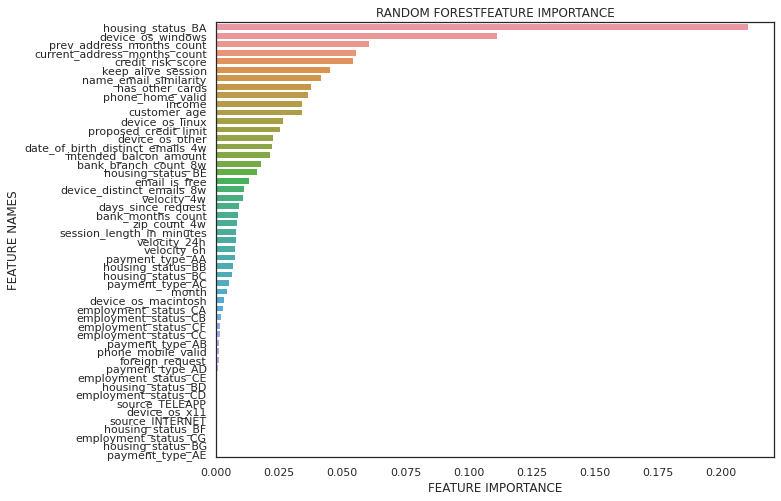

In [59]:
plot_feature_importance(rf.feature_importances_,x_res.columns,'RANDOM FOREST')